# Содержание
1. [Импорты](#Импорты)
2. [Предварительная обработка и анализ данных](#Предварительная-обработка-и-анализ-данных)  
    2.1. [Данные об электродах — data_arc.csv](#data_arc.csv)  
    2.2. [Данные о подаче сыпучих материалов (объём) — data_bulk.csv](#data_bulk.csv)   
    2.3. [Данные о подаче сыпучих материалов (время) — data_bulk_time.csv](#data_bulk_time.csv)  
    2.4. [Данные о проволочных материалах (объём) — data_wire.csv](#data_wire.csv)  
    2.5. [Данные о проволочных материалах (время) — data_wire_time.csv](#data_wire_time.csv)  
    2.6. [Данные о продувке сплава газом — data_gas.csv](#data_gas.csv)  
    2.7. [Результаты измерения температуры — data_temp.csv](#data_temp.csv)  
3. [Отбор подходящих партий](#Отбор-подходящих-партий)
4. [Создание таблицы признаков для машинного обучения](#Создание-таблицы-признаков-для-машинного-обучения)
5. [План дальнейших действий](#План-дальнейших-действий)
6. [Вопросы к тимлиду](#Вопросы-к-тимлиду)

### Импорты

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt

---

### Предварительная обработка и анализ данных
[вернуться к содержанию](#Содержание)

In [2]:
#path = 'C:/Users/Vladimir/Documents/Jupiter/Projects/Final/final_steel/final_steel/' # когда делаешь дома
path = '/datasets/final_steel/' # когда делаешь через ЯП

In [3]:
for filename in os.listdir(path):
    print(filename)

data_gas.csv
data_bulk.csv
data_bulk_time.csv
data_wire_time.csv
data_arc.csv
data_temp.csv
data_wire.csv


---

#### data_arc.csv
<b>Данные об электродах</b>


[вернуться к содержанию](#Содержание)

In [4]:
data_arc = pd.read_csv(path+'data_arc.csv')
data_arc.info()
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


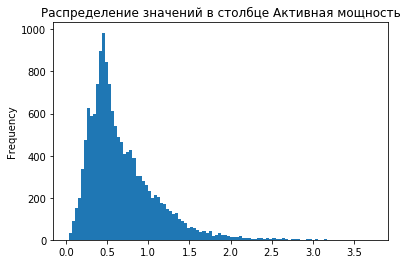

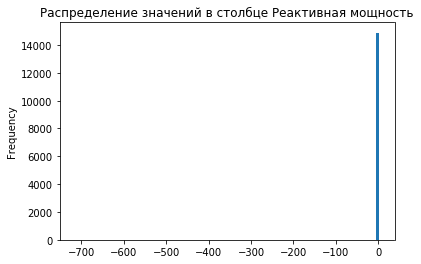

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
1%,33.000000,0.112734,0.080714
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
99%,3205.000000,2.079994,1.592817
max,3241.000000,3.731596,2.676388


In [5]:
data_arc['Активная мощность'].plot(kind='hist', title='Распределение значений в столбце Активная мощность', bins=100)
plt.show()
data_arc['Реактивная мощность'].plot(kind='hist', title='Распределение значений в столбце Реактивная мощность', bins=100)
plt.show()
data_arc.describe(percentiles=[.01, .25, .5, .75, .99])

Пропусков в данных нет. В столбце "Активная мощность" данные в порядке. Среднее значение больше медианы, значит данные скошены, что видно и на гистограмме плотности. 

В столбце "Реактивная мощность" есть ошибочно введенные данные, ведь в данном мощность не может быть отрицательной, к тому же значение на несколько порядков больше остальных по модулю. Анализировать медиану и среднее нельзя, такое большое отрицательное значение искажает среднее значение по датасету, так что от него необходимо избавиться.

Но предварительно переименуем столбцы для удобства работы с ними.

In [6]:
# переименование столбцов на латинице, перевод названий столбцов в нижний регистр
data_arc.columns = ['key', 'heat_start', 'heat_finish', 'active_power', 'reactive_power']

# смена типа данных на datetime в столбцах с датой
data_arc['heat_start'] = pd.to_datetime(data_arc['heat_start'], format='%Y-%m-%d %H:%M:%S') 
data_arc['heat_finish'] = pd.to_datetime(data_arc['heat_finish'], format='%Y-%m-%d %H:%M:%S')

Теперь посмотрим на ошибочное значение.

In [7]:
data_arc[data_arc['reactive_power'] < 0]

,key,heat_start,heat_finish,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Всего одно значение. При этом значение активной мощности в этом наблюдении близко к медианному. Заменим ошибочное значение реактивной мощности медианным значением этого признака.

In [8]:
data_arc.loc[data_arc[data_arc['reactive_power'] < 0].index, 'reactive_power'] = data_arc['reactive_power'].median()

Взглянем на распределение и описание данных снова.

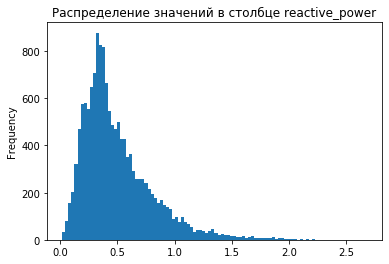

count    14876.000000
mean         0.500718
std          0.310871
min          0.020806
1%           0.080798
25%          0.291008
50%          0.415973
75%          0.637371
99%          1.592817
max          2.676388
Name: reactive_power, dtype: float64

In [9]:
data_arc['reactive_power'].plot(kind='hist', title='Распределение значений в столбце reactive_power', bins=100)
plt.show()
data_arc['reactive_power'].describe(percentiles=[.01, .25, .5, .75, .99])

Ошибочных данных не видно. Среднее значение действительно заметно увеличилось.

Суммарное количество затраченной на нагрев партии мощности будет одним из признаков, на которых мы будем строить модель, посчитаем суммарные активную и реактивную мощности по каждой партии.

In [10]:
powers_sum = data_arc.pivot_table(values=['active_power', 'reactive_power'], index='key', aggfunc=['sum'])
powers_sum.columns = ['active_power', 'reactive_power']

In [11]:
powers_sum.describe(percentiles=[.01, .25, .5, .75, .99])

,active_power,reactive_power
count,3214.000000,3214.000000
mean,3.103138,2.317572
std,1.397390,1.054169
min,0.186226,0.158247
1%,0.570899,0.401643
25%,2.126339,1.599018
50%,2.990537,2.229869
75%,3.901147,2.899141
99%,6.927170,5.375642
max,17.496497,12.587990


In [12]:
powers_sum.corr()

,active_power,reactive_power
active_power,1.000000,0.957882
reactive_power,0.957882,1.000000


Между двумя мощностями есть сильная корреляция. Это логично, чем больше "полезная" мощность (активная), тем больше и "бесполезная" (реактивная) мощность. Они подчиняются треугольнику мощностей и завият от общей мощности и фазового угла.

Не вдаваясь в физические подробности, корелляция между этими двумя величинами ожидаема, а значит можем отказаться от "бесполезной" реактивной, используя в дальнейшем только активную.

In [13]:
powers_sum = powers_sum.drop('reactive_power', axis=1)

Так же для того, чтобы выделить партии, в которые после измерения температуры не вносились какие-то изменения (подогрев, введение сыпучих и проволочных материалов), нам необходимо отобрать наиболее позднее время окончания подогрева каждой партии для последующего сравнения с временем последнего измерения температуры партии. Сохраним список партий и время их последнего подогрева в отдельную переменную.

In [14]:
heat_last = data_arc.pivot_table(values=['heat_finish'], index='key', columns=None, aggfunc=['max'])
heat_last.columns = ['heat_finish_time']
heat_last

,heat_finish_time
key,
1,2019-05-03 11:28:37
2,2019-05-03 11:53:18
3,2019-05-03 12:32:19
4,2019-05-03 12:57:50
5,2019-05-03 13:33:55
...,...
3237,2019-08-31 23:03:48
3238,2019-08-31 23:41:28
3239,2019-09-01 02:15:43


Результат:
* данные проанализированы и очищены от ошибок и выбросов;
* типы данных преобразованы;
* создана отдельная переменная окончания подогрева.

---

#### data_bulk.csv
<b>Данные о подаче сыпучих материалов (объём)</b>

    
[вернуться к содержанию](#Содержание)

In [15]:
data_bulk = pd.read_csv(path+'data_bulk.csv')
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [16]:
data_bulk.describe(percentiles=[.01, .25, .5, .75, .99])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
1%,32.280000,17.530000,228.000000,19.000000,19.000000,16.320000,25.000000,47.720000,49.0,63.360000,27.500000,14.000000,103.000000,151.170000,90.000000,54.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
99%,3208.720000,98.900000,315.970000,343.180000,239.000000,367.400000,351.750000,724.960000,49.0,140.520000,148.750000,229.840000,570.000000,300.410000,374.800000,240.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В очень большой части партий применялись присадки 12, 14 и 15. Видимо, это какие-то обязательные необходимые элементы и вещества. Количество остальных очень разнится. К примеру, присадка под номером 8 за имеющееся время наблюдений применялась всего единожды.

Наименования столбцов необходимо привести в нижний регистр и убрать из них пробелы. Кроме того в данных огромное количество пропусков. Было установлено, что пропуски возникали потому что в конкретную партию не добавлялась конкретная присадка. В таком случае не будет ошибкой заменить пропуски в этой таблице нулями.

In [17]:
# перевод названий столбцов в нижний регистр и замена пробелов подчеркиванием
data_bulk_columns = ['key']
for i in range(len(data_bulk.columns)-1):
    data_bulk_columns.append('bulk_'+str(i+1))
data_bulk.columns = data_bulk_columns

# замена пропущеных значений нулями
data_bulk = data_bulk.fillna(0)

Результат:
* данные обработаны, очищены от пропусков
* приведены к виду, в котором будут использованы при обучении модели

In [18]:
data_bulk.info()
data_bulk.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
bulk_1     3129 non-null float64
bulk_2     3129 non-null float64
bulk_3     3129 non-null float64
bulk_4     3129 non-null float64
bulk_5     3129 non-null float64
bulk_6     3129 non-null float64
bulk_7     3129 non-null float64
bulk_8     3129 non-null float64
bulk_9     3129 non-null float64
bulk_10    3129 non-null float64
bulk_11    3129 non-null float64
bulk_12    3129 non-null float64
bulk_13    3129 non-null float64
bulk_14    3129 non-null float64
bulk_15    3129 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0


Так как данных очень много, оценим корреляцию графически. На графике ниже нулевому столбцу соответствует столбец с ключами, корреляции там мы не ищем. Остальные номера столбцов соответствуют номерам присадок.

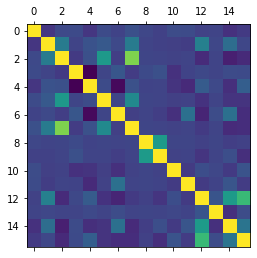

In [19]:
plt.matshow(data_bulk.corr())
plt.show()

Есть очень сильная корреляция между 2 и 7 присадками. Моя версия - эта комбинация присадок подается в какой-то сплав, и отсутстствует в остальных. Кроме-то сильно коррелируют 12, 14 и 15 присадки, это связано с тем, что они присутствуют в большинстве партий.

---

#### data_bulk_time.csv
<b>Данные о подаче сыпучих материалов (время)</b>

    
[вернуться к содержанию](#Содержание)

In [20]:
data_bulk_time = pd.read_csv(path+'data_bulk_time.csv')
data_bulk_time.info()
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Аналогично прошлой таблице, преобразуем названия столбцов. Кроме того изменим тип данных и тип пропусков для того, чтобы иметь возможность сравнивать значения.

In [21]:
# перевод названий столбцов в нижний регистр и замена пробелов подчеркиванием
data_bulk_time_columns = ['key']
for i in range(len(data_bulk_time.columns)-1):
    data_bulk_time_columns.append('bulk_'+str(i+1))
data_bulk_time.columns = data_bulk_time_columns

# смена типа данных на datetime в столбцах с датой
for i in data_bulk_time.columns[1:]:
    data_bulk_time[i] = pd.to_datetime(data_bulk_time[i], format='%Y-%m-%d %H:%M:%S', errors='coerce')

Для нашей работы необходимо будет проверить, чтобы в партию не вносились какие-то изменения (подогрев, введение сыпучих и проволочных материалов) после последнего измерения температуры партии. 
Для этого определим время последнего введения в партию сыпучих присадок и сохраним список дат и номера партий в переменную для дальнейшего использования.

In [22]:
data_bulk_time['bulk_time'] = data_bulk_time[data_bulk_time_columns[1:]].max(axis=1)
data_bulk_time = data_bulk_time.drop(data_bulk_time_columns[1:], axis=1)

Результат:
* данные исследованы, определено время последнего введения сыпучих присадок в состав каждой партии и сохранено для дальнейшего использования

In [23]:
data_bulk_time.info()
data_bulk_time.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 2 columns):
key          3129 non-null int64
bulk_time    3129 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 49.0 KB


,key,bulk_time
0,1,2019-05-03 11:21:30
1,2,2019-05-03 11:46:38
2,3,2019-05-03 12:31:06
3,4,2019-05-03 12:48:43
4,5,2019-05-03 13:18:50


---

#### data_wire.csv
<b>Данные о проволочных материалах (объём)</b>

    
[вернуться к содержанию](#Содержание)

In [24]:
data_wire = pd.read_csv(path+'data_wire.csv')
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data_wire.describe(percentiles=[.01, .25, .5, .75, .99])

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
1%,31.800000,13.060320,4.125285,0.144144,24.276700,15.132,0.108451,0.316181,45.076721,5.499313
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
99%,3210.200000,209.267394,181.311065,349.188221,111.905543,15.132,155.027565,30.798354,101.409133,82.491139
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Как и в таблице с объемами сыпучих матреиалов, наименования столбцов необходимо привести в нижний регистр и убрать из них пробелы. Кроме того в данных огромное количество пропусков. Было установлено, что пропуски возникали потому что в конкретную партию не добавлялась конкретная присадка. В таком случае не будет ошибкой заменить пропуски в этой таблице нулями.

In [26]:
# перевод названий столбцов в нижний регистр и замена пробелов подчеркиванием
data_wire_columns = ['key']
for i in range(len(data_wire.columns)-1):
    data_wire_columns.append('wire_'+str(i+1))
data_wire.columns = data_wire_columns

# замена пропущеных значений нулями
data_wire = data_wire.fillna(0)

Результат:
* данные обработаны, очищены от пропусков
* приведены к виду, в котором будут использованы при обучении модели

In [27]:
data_wire.info()
data_wire.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
wire_1    3081 non-null float64
wire_2    3081 non-null float64
wire_3    3081 non-null float64
wire_4    3081 non-null float64
wire_5    3081 non-null float64
wire_6    3081 non-null float64
wire_7    3081 non-null float64
wire_8    3081 non-null float64
wire_9    3081 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Изучим корреляцию проводных присадок. Как и ранее, столбец под номером 0 на графике обозначает столбец с "ключами" партий и не несет полезной информации.

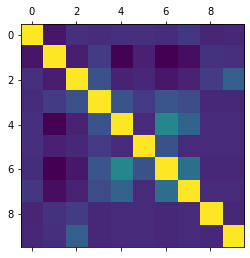

In [28]:
plt.matshow(data_wire.corr())
plt.show()

В отличие от сыпучих добавок, тут матрица почти вся "холодная", проводные присадки слабо коррелируют друг с другом и не показывают закономерностей.

---

#### data_wire_time.csv
<b>Данные о проволочных материалах (время)</b>

    
[вернуться к содержанию](#Содержание)

In [29]:
data_wire_time = pd.read_csv(path+'data_wire_time.csv')
data_wire_time.info()
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Так же как и в данных о сыпучих материалах, преобразуем названия столбцов. Кроме того изменим тип данных и тип пропусков для того, чтобы иметь возможность сравнивать значения.

In [30]:
# перевод названий столбцов в нижний регистр и замена пробелов подчеркиванием
data_wire_time_columns = ['key']
for i in range(len(data_wire_time.columns)-1):
    data_wire_time_columns.append('wire_'+str(i+1))
data_wire_time.columns = data_wire_time_columns

# смена типа данных на datetime в столбцах с датой
for i in data_wire_time.columns[1:]:
    data_wire_time[i] = pd.to_datetime(data_wire_time[i], format='%Y-%m-%d %H:%M:%S', errors='coerce')

И вновь получим время последнего введения присадки (в данном случае проволоки) для каждой партии. Полученый результат перезапишем в переменную, она пригодится нам для сравнения, о котором я писал ранее.

In [31]:
data_wire_time['wire_time'] = data_wire_time[data_wire_time_columns[1:]].max(axis=1)
data_wire_time = data_wire_time.drop(data_wire_time_columns[1:], axis=1)

Результат:
* данные исследованы, определено время последнего вмешательства в состав каждой партии и сохранено для дальнейшего использования

In [32]:
data_wire_time.info()
data_wire_time.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 2 columns):
key          3081 non-null int64
wire_time    3081 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 48.3 KB


,key,wire_time
0,1,2019-05-03 11:11:41
1,2,2019-05-03 11:46:10
2,3,2019-05-03 12:13:47
3,4,2019-05-03 12:48:05
4,5,2019-05-03 13:32:06


---

#### data_gas.csv
<b>Данные о продувке сплава газом</b>

    
[вернуться к содержанию](#Содержание)

In [33]:
data_gas = pd.read_csv(path+'data_gas.csv')
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


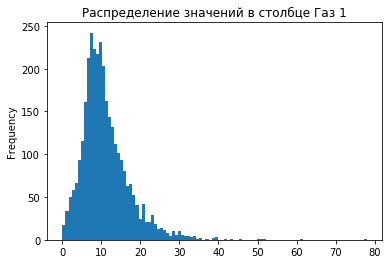

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
1%,33.380000,1.132655
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
99%,3208.620000,31.558630
max,3241.000000,77.995040


In [34]:
data_gas['Газ 1'].plot(kind='hist', title='Распределение значений в столбце Газ 1', bins=100)
plt.show()
data_gas.describe(percentiles=[.01, .25, .5, .75, .99])

Необходимо привести наименование столбцов к нижнему регистру на латинице, заменить пробелы подчеркиванием. 

Пропуски в данных отсутствуют. Откровенных ошибок в данных нет.

In [35]:
# перевод названий столбцов в нижний регистр и замена пробелов подчеркиванием
data_gas_columns = ['key']
for i in range(len(data_gas.columns)-1):
    data_gas_columns.append('gas_'+str(i+1))
data_gas.columns = data_gas_columns

In [36]:
data_gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


---

#### data_temp.csv
<b>Результаты измерения температуры</b>

    
[вернуться к содержанию](#Содержание)

In [37]:
data_temp = pd.read_csv(path+'data_temp.csv')
data_temp.info()
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Столбцы в данных необходимо переименовать на латинице в нижнем регистре, заменить пробелы на подчеркивания. Тип данных в стобце времени изменить на datetime. Кроме того, в данных большое количество пропусков. Все эти пропуски выглядят так, будто бы у партии была измерена первичная температура, затем внесены какие-то изменения состава, но последующих измерений не проводилось. Почему так происходило, я так и не разобрался, вынес этот вопрос в конец, в вопросы тимлиду. Сами пропуски в данных на текущий момент я обработал дальше, когда сгрупировал их в отдельную таблицу.

In [38]:
# переименование столбцов на латинице, перевод названий столбцов в нижний регистр
data_temp.columns = ['key', 'time', 'temp']

# смена типа данных на datetime в столбцах с датой
data_temp['time'] = pd.to_datetime(data_temp['time'], format='%Y-%m-%d %H:%M:%S')

In [39]:
data_temp.info()
data_temp.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key     15907 non-null int64
time    15907 non-null datetime64[ns]
temp    13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


,key,time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0


Теперь, когда данные проебразованы для удобства работы, выделим из них необходимые нам. Для начала проверим одну теорию. Так как партии не обрабатывались одновременно, а внутри каждой партии измерения температуры не происходили одновременно, есть гипотеза, что в этой таблице каждая отметка времени - уникальна и может быть в дальнейшем для нахождения нужной температуры. Проверим эту гипотезу:

In [40]:
data_temp['time'].value_counts()

2019-08-28 20:36:18    1
2019-06-13 00:35:03    1
2019-08-06 02:04:21    1
2019-06-12 05:55:41    1
2019-08-02 21:06:00    1
                      ..
2019-07-30 04:16:22    1
2019-08-30 10:22:56    1
2019-05-05 21:57:17    1
2019-05-31 03:54:21    1
2019-05-09 08:58:14    1
Name: time, Length: 15907, dtype: int64

Так и есть, каждая отметка времени из 15907 уникальна. Это значит, что по ним как по индексам можно будет отбирать данные. Отберем температруры каждой партии в начале обработки, так как это значение может быть одним из признаков при создании модели.

Для этого сначала отбереме минимальное (то есть наиболее раннее время) измерения каждой партии, а затем по этим датам выберем температуры.

In [41]:
start_dates_temp = data_temp.pivot_table(values='time', index='key', columns=None, aggfunc=['min'])
start_dates_temp.columns = ['time']

In [42]:
start_temp = pd.merge(start_dates_temp,
                      data_temp,
                      on='time',
                      how='left')
start_temp.columns = ['first_measure_time', 'key', 'start_temp']

In [43]:
start_temp = start_temp.drop('first_measure_time', axis=1)
start_temp

,key,start_temp
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0
...,...,...
3211,3237,1569.0
3212,3238,1584.0
3213,3239,1598.0
3214,3240,1617.0


Кроме того нам необходимо проверить, чтобы последнее измерение температуры партии происходило после всех остальных операций (подогрев, введение сыпучих и проволочных материалов). Это будет означать, что это температура сырья непосредственно перед розливом. Для этого нам необходимы даты последних измерений температур партий (то есть "максимальное" время измерения температуры партии).

In [44]:
finish_dates_temp = data_temp.pivot_table(values='time', index='key', columns=None, aggfunc=['max'])
finish_dates_temp.columns = ['time']

In [45]:
finish_temp = pd.merge(finish_dates_temp,
                      data_temp,
                      on='time',
                      how='left')

finish_temp.columns = ['last_measure_time', 'key', 'target_temp']

Кроме того, последнее измерение температуры партии является нашим целевым признаком. А значит мы используем эту таблицу в дальнейшем, оставив температуры. Как можно увидеть ниже, не у всех партий была измерена температура, из-за этого в данных возникли пропуски. Я не смог разобраться, почему не проводились измерения, и об этом задал вопрос тимлиду ниже. Таким образом у данных партий целевой признак отсутствует, а значит их нельзя использовать для обучения модели. Поэтому я решил исключить это партии из данных. 

In [46]:
finish_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 3 columns):
last_measure_time    3216 non-null datetime64[ns]
key                  3216 non-null int64
target_temp          2477 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 100.5 KB


In [47]:
finish_temp = finish_temp.dropna()
finish_temp

,last_measure_time,key,target_temp
0,2019-05-03 11:30:39,1,1613.0
1,2019-05-03 11:59:12,2,1602.0
2,2019-05-03 12:34:57,3,1599.0
3,2019-05-03 12:59:25,4,1625.0
4,2019-05-03 13:36:01,5,1602.0
...,...,...,...
2472,2019-08-06 00:54:42,2495,1591.0
2473,2019-08-06 01:29:52,2496,1591.0
2474,2019-08-06 01:53:50,2497,1589.0
2475,2019-08-06 02:25:31,2498,1594.0


In [48]:
finish_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 3 columns):
last_measure_time    2477 non-null datetime64[ns]
key                  2477 non-null int64
target_temp          2477 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 77.4 KB


---

### Отбор подходящих партий
[вернуться к содержанию](#Содержание)

Создадим сводную таблицу для сравнения времени последнего измерения температуры партии и внесения изменений в партию.

In [49]:
timings = heat_last
timings = pd.merge(timings,
                   data_bulk_time,
                   on='key',
                   how='left')
timings = pd.merge(timings,
                   data_wire_time,
                   on='key',
                   how='left')
timings = pd.merge(timings,
                   finish_temp.drop('target_temp', axis=1),
                   on='key',
                   how='left')

In [50]:
timings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
key                  3214 non-null int64
heat_finish_time     3214 non-null datetime64[ns]
bulk_time            3128 non-null datetime64[ns]
wire_time            3080 non-null datetime64[ns]
last_measure_time    2475 non-null datetime64[ns]
dtypes: datetime64[ns](4), int64(1)
memory usage: 150.7 KB


Из-за того, что по некоторым партиям у нас отсутствовало время последнего измерения температуры или введения той или иной присадки, в итоговой таблице есть пропуски, проверить данные по этим партиям мы, к сожалению, не сможем. Поэтому их тоже проидется изключить из иготового датасета.

In [51]:
timings = timings.dropna()
timings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2474
Data columns (total 5 columns):
key                  2331 non-null int64
heat_finish_time     2331 non-null datetime64[ns]
bulk_time            2331 non-null datetime64[ns]
wire_time            2331 non-null datetime64[ns]
last_measure_time    2331 non-null datetime64[ns]
dtypes: datetime64[ns](4), int64(1)
memory usage: 109.3 KB


In [52]:
keys = []
for i in timings.index:
    if (timings.loc[i, 'last_measure_time'] > timings.loc[i,'bulk_time']) and (timings.loc[i, 'last_measure_time'] > timings.loc[i,'wire_time']) and (timings.loc[i, 'last_measure_time'] > timings.loc[i,'heat_finish_time']):
        keys.append(timings.loc[i, 'key'])

В результате мы получили список "ключей" партий, которые и будем использовать для обучения модели. 

In [53]:
len(keys)

2208

---

### Создание таблицы признаков для машинного обучения
[вернуться к содержанию](#Содержание)

По списку партий, подходящих по времени, соберем датасет признаков.

In [54]:
features = pd.DataFrame(data=keys, columns=['key'])
features = pd.merge(features,
                    powers_sum,
                    on='key',
                    how='left')
features = pd.merge(features,
                    data_bulk,
                    on='key',
                    how='left')
features = pd.merge(features,
                    data_wire,
                    on='key',
                    how='left')
features = pd.merge(features,
                    data_gas,
                    on='key',
                    how='left')
features = pd.merge(features,
                    start_temp,
                    on='key',
                    how='left')
features = pd.merge(features,
                    finish_temp,
                    on='key',
                    how='left')

In [55]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208 entries, 0 to 2207
Data columns (total 30 columns):
key                  2208 non-null int64
active_power         2208 non-null float64
bulk_1               2208 non-null float64
bulk_2               2208 non-null float64
bulk_3               2208 non-null float64
bulk_4               2208 non-null float64
bulk_5               2208 non-null float64
bulk_6               2208 non-null float64
bulk_7               2208 non-null float64
bulk_8               2208 non-null float64
bulk_9               2208 non-null float64
bulk_10              2208 non-null float64
bulk_11              2208 non-null float64
bulk_12              2208 non-null float64
bulk_13              2208 non-null float64
bulk_14              2208 non-null float64
bulk_15              2208 non-null float64
wire_1               2208 non-null float64
wire_2               2208 non-null float64
wire_3               2208 non-null float64
wire_4               2208 non-null 

Два пропуска в данных по газу: из всех отобранных партий у двух отсутствует информация по обработке газом. Сложно сказать, связано это с тем, что газ не подавался или данные просто не внесли. Проще всего будет просто удалить эти две партии.

Наведем лоску на нашу таблицу признаков: уберем номера партий из содержимого датасета в его индексы и удалим столбец с датой измерения последней температуры.

In [56]:
features.index = features['key']
features = features.dropna().drop(['key', 'last_measure_time'], axis=1)

In [57]:
features.head(5)

,active_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,start_temp,target_temp
key,,,,,,,,,,,,,,,,,,,,,
1,4.878147,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0
2,3.052598,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0
3,2.525882,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0,1599.0
4,3.209250,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0,1625.0
5,3.347173,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0,1602.0


Посомтроим на корреляцию итоговых признаков. 

Для понимания графика корреляции ниже требуется знать следующее:
* ряд номер 0 обозначает активную мощность;
* ряды с 1 по 15 включительно содержат корреляции по сыпучим присадкам;
* ряды с 16 по 24 включительно содержат корреляции по присадкам, подаваемым в виде провода;
* ряд 25 это информация о корелляции других признаков с поданным количеством инертного газа;
* ряд 26 обозначает корреляции с изначальной температурой партии;
* ряд 27 показывает корреляции признаков с финальной температурой партии.

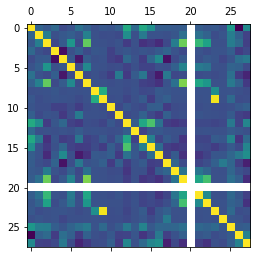

In [58]:
plt.matshow(features.corr())
plt.show()

Белая полоса на графике означает что по кабельной присадке номер 5 все данные равны нулю. Так получилось из-за того, что изначально там было всего одно значение, и, судя по всему оно потерялось при отсеве не подходящих партий. 

Еще на графике можно увидеть очень сильную корреляцию между сыпучей присадкой 9 и кабельной присадкой номер 8. Моя версия, это значит что эти две присадки всегда применяются вместе. Вообще таких комбинаций довольно много, но там корреляции не такие сильные. К примеру, у сыпучих присадок номер 2 и 7 высока корреляция с кабельной присадкой номер 4.

---

### План дальнейших действий
[вернуться к содержанию](#Содержание)

1. <b>Подготовка признаков.</b> Полученные данные я разделю на обучающие признаки и целевой. Целевым признаком будет являться окончательная температура стали перед розливом.
2. <b>Выбор набора моделей.</b> Я возьму несколько регрессионных моделей, использующих разные алгоритмы (линейные, древо решений, ансамблевые модели, метод ближайших соседей). Так же попробую модели с применением градиентного бустинга.
3. <b>Подбор оптимальных гиперпараметров моделей и определение их качества.</b> Используя кросс-валидацию, подберу оптимальные гиперпараметры каждой модели и определю качество каждой модели согласно требуемой метрики.
4. <b>Выбор и анализ наилучшей модели.</b> Сравню качесвто моделей используя требуемую метрику и выберу модель наиболее подходящую к задаче. Проанализирую веса признаков, определенные моделью, сделаю выводы, возможно оптимизирую процесс обработки признаков.

---

In [60]:
features.to_csv('steel_features.csv')